In [1]:
import sys
sys.path.append("../src")
print(sys.path)
# autoreload
import lightgbm as lgb

#from testbed.models.quantile_regression import QuantileRegression
from testbed.models.treeffuser import Treeffuser
from testbed.models.baltobotmodel import BaltoBotModel
import pandas as pd
import numpy as np

from pathlib import Path
from tqdm import tqdm
import pickle as pkl



#from testbed.models.ngboost import NGBoostGaussian, NGBoostMixtureGaussian, NGBoostPoisson
from testbed.models.base_model import BayesOptProbabilisticModel


from functools import partial

from jaxtyping import Float, Array
from typing import List, Callable

import seaborn as sns
import matplotlib.pyplot as plt
from testbed.metrics.log_likelihood import LogLikelihoodFromSamplesMetric
from testbed.metrics.crps import CRPS
from testbed.metrics.accuracy import AccuracyMetric


path = "/Users/cmccarter/sandbox/treeffuser/testbed/src/testbed/data/m5"

# load autoreload extension


['/Users/cmccarter/miniconda3/envs/maskingtrees/lib/python39.zip', '/Users/cmccarter/miniconda3/envs/maskingtrees/lib/python3.9', '/Users/cmccarter/miniconda3/envs/maskingtrees/lib/python3.9/lib-dynload', '', '/Users/cmccarter/.local/lib/python3.9/site-packages', '/Users/cmccarter/miniconda3/envs/maskingtrees/lib/python3.9/site-packages', '/Users/cmccarter/sandbox/treeffuser/testbed/src', '/Users/cmccarter/sandbox/treeffuser/src', '../src']


In [2]:
# These are config variables

PROCESS_FROM_SCRATCH = True
USE_SUBSET = True
CONTEXT_LENGTH = 20
RUN_DEPRECATED = False

In [3]:
# READ IN DATA

sell_prices_df = pd.read_csv(Path(path) / "sell_prices.csv")
sales_train_validation_df = pd.read_csv(Path(path) / "sales_train_validation.csv")
calendar_df = pd.read_csv(Path(path) / "calendar.csv")

print("\ncolumns of sell_prices_df:")
[print(col) for col in sell_prices_df.columns]
print("\ncolumns of sales_train_validation_df:")
[print(col) for col in sales_train_validation_df.columns if not col.startswith("d_")]
print("\ncolumns of calendar_df:") # ommit d_1, d_2, ..., d_1913
[print(col) for col in calendar_df.columns if not col.startswith("d_")]

""

# print number of zeros
print("number of zeros in sales_train_validation_df: ", (sales_train_validation_df == 0).sum().sum())


columns of sell_prices_df:
store_id
item_id
wm_yr_wk
sell_price

columns of sales_train_validation_df:
id
item_id
dept_id
cat_id
store_id
state_id

columns of calendar_df:
date
wm_yr_wk
weekday
wday
month
year
d
event_name_1
event_type_1
event_name_2
event_type_2
snap_CA
snap_TX
snap_WI
number of zeros in sales_train_validation_df:  39777094


In [4]:
#num_zeros = sales_train_validation_df.isin([0]).sum().sum()
#total_entries =   sales_train_validation_df.

items_sold_cols = sales_train_validation_df.columns[sales_train_validation_df.columns.str.startswith("d_")]
num_zeros = (sales_train_validation_df[items_sold_cols] == 0).sum().sum()
total_entries = sales_train_validation_df[items_sold_cols].shape[0] * sales_train_validation_df[items_sold_cols].shape[1]

print(f"number of zeros in sales_train_validation_df: {num_zeros} out of {total_entries} entries")
print(f"percentage of zeros in sales_train_validation_df: {num_zeros / total_entries * 100:.2f}%")

number of zeros in sales_train_validation_df: 39777094 out of 58327370 entries
percentage of zeros in sales_train_validation_df: 68.20%


In [5]:
# add explicit columns for the day, month, year for ease of processing
calendar_df["date"] = pd.to_datetime(calendar_df["date"])
calendar_df["day"] = calendar_df["date"].dt.day
calendar_df["month"] = calendar_df["date"].dt.month
calendar_df["year"] = calendar_df["date"].dt.year


# Brief snapshots of the dataset

In [6]:
calendar_df.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,day
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0,29
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0,30
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0,31
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0,1
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1,2


In [7]:
sales_train_validation_df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


In [8]:
sell_prices_df.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


# Process the data

In [9]:
TOTAL_ITEMS = 5000
# select a random subset of items
if USE_SUBSET:
    np.random.seed(0)
    unique_ids = sales_train_validation_df["id"].unique()
    ids = np.random.choice(sales_train_validation_df["id"].unique(), TOTAL_ITEMS, replace=False)
    sales_train_validation_df_sub = sales_train_validation_df[sales_train_validation_df["id"].isin(ids)]
    item_ids = sales_train_validation_df_sub["item_id"].unique()
    sell_prices_df_sub = sell_prices_df[sell_prices_df["item_id"].isin(item_ids)]
    calendar_df_sub = calendar_df





columns_sales_train_validation.head)

The strategy for processing the data is going to be the following. 1) We are going to have X and y where y is the next days sales for a given product. 3) X is made up of 10 previous prices, day of the week, + event types, cat_id, store_id, state_id

In [10]:
def proc_train_test(sales_train_validation_df: pd.DataFrame, calendar_df: pd.DataFrame, sell_prices_df: pd.DataFrame, context_length: int, test_percentage: float, percentage_omittied: int = 0): #type annotation too long
    """
    This function processes the data and returns the training and test data in two ways:
    - undifferentiated: a list of all training and test data (X_train, y_train, X_test, y_test)
    - differentiated: a list of training and test data for each product (X_train_prod, y_train_prod, X_test_prod, y_test_prod)
        where X_train_prod[i] contains a list of all X_train values for the product i with similar grouping for y_train_prod and test

    This assumes from the dataframes that
    - sales_train_validation_df:
        - has columns with the format d_1, d_2, ...
        - has columns item_id and store_id
    - calendar_df:
        - wday, month, event_name_1, event_name_2
    - sell_prices_df:
        - item_id, store_id, sell_price

    - percentage_omittied: percentage of the data to be omitted from the training data and the test data
        (randomly selected)

    Returns:
    - undifferentiated: Tuple of X_train, y_train, X_test, y_test
    - differentiated: Tuple of X_train_prod, y_train_prod, X_test_prod, y_test_prod
    """
    np.random.seed(0)
    # First we need to get the training data
    # We will use the first 1913 days as training data and the next

    X_train = []
    y_train = []

    X_test = []
    y_test = []

    # We will also return a second grouping of lists where X_train_prod[i] contains a
    # a list of all X_train values for the product i with similar grouping for y_train_prod and test
    X_train_prod = []
    y_train_prod = []
    X_test_prod = []
    y_test_prod = []


    # get all days that start with d_ and look for the maximum
    total_days = max([int(x.split("_")[1]) for x in sales_train_validation_df.columns if "d_" in x])
    train_days = int(total_days * (1 - test_percentage))
    print("train days", train_days)
    print("test days", total_days - train_days)
    print("total days", total_days)

    # Precompute the required data
    calendar_df_dict = calendar_df.set_index("d").to_dict(orient="index")
    sell_prices_dict = sell_prices_df.groupby(["item_id", "store_id"])["sell_price"].first().to_dict()

    pbar = tqdm(total=len(sales_train_validation_df))
    for _, row in sales_train_validation_df.iterrows():
        item_id = row["item_id"]
        store_id = row["store_id"]

        X_train_prod.append([])
        y_train_prod.append([])
        X_test_prod.append([])
        y_test_prod.append([])

        pbar.update(1)

        valid_size = int((train_days - context_length) * (1 - percentage_omittied))
        valid_js = np.random.choice(range(1, train_days - context_length), valid_size, replace=False)

        valid_js = list(valid_js) + list(range(train_days, total_days - context_length))

        for j in valid_js:
            x = []

            # Add sales values for the previous context_length days
            x.extend(row[f"d_{j+k}"] for k in range(context_length))

            # Add additional features
            current_day = f"d_{j+context_length}"
            calendar_data = calendar_df_dict[current_day]
            x.extend([
                calendar_data["wday"],
                calendar_data["month"],
                store_id,
                calendar_data["event_name_1"],
                calendar_data["event_name_2"],
                sell_prices_dict[(item_id, store_id)],
                item_id
            ])

            if j < train_days:
                X_train.append(x)
                y_train.append(row[current_day])
                X_train_prod[-1].append(x)
                y_train_prod[-1].append(row[current_day])

            else:
                X_test.append(x)
                y_test.append(row[current_day])
                X_train_prod[-1].append(x)
                y_train_prod[-1].append(row[current_day])

    undifferentiated = (X_train, y_train, X_test, y_test)
    differentiated = (X_train_prod, y_train_prod, X_test_prod, y_test_prod)
    return undifferentiated, differentiated

In [11]:
if PROCESS_FROM_SCRATCH:
    undifferentiated, differentiated = proc_train_test(sales_train_validation_df_sub, calendar_df, sell_prices_df_sub, CONTEXT_LENGTH, 0.02, 0.99)
    X_train, y_train, X_test, y_test = undifferentiated
    X_train_prod, y_train_prod, X_test_prod, y_test_prod = differentiated


train days 1874
test days 39
total days 1913


100%|████████████████████████████████████████████████████████████████████| 5000/5000 [00:04<00:00, 1202.75it/s]


In [12]:
len(X_train), len(y_train), len(X_test), len(y_test)

(90000, 90000, 95000, 95000)

In [13]:
COL_NAMES = [
    f"day_{i}" for i in range(1, CONTEXT_LENGTH+1)
] + ["wday", "month", "store_id", "event_name_1", "event_name_2", "sell_price", "item_id"]

CAT_COLS = ["store_id", "event_name_1", "event_name_2", "item_id", "wday", "month"]
CAT_COLS_IDX = [COL_NAMES.index(col) for col in CAT_COLS]


In [14]:
X_train_df = pd.DataFrame(X_train)
X_test_df = pd.DataFrame(X_test)
y_test_df = pd.DataFrame(y_test)
y_train_df = pd.DataFrame(y_train)

X_train_df.columns = COL_NAMES
X_test_df.columns = COL_NAMES

In [15]:

X_train_df

,day_1,day_2,day_3,day_4,day_5,day_6,day_7,day_8,day_9,day_10,...,day_18,day_19,day_20,wday,month,store_id,event_name_1,event_name_2,sell_price,item_id
0,2,0,0,4,1,0,6,0,0,0,...,1,2,0,2,2,CA_1,NaN,NaN,2.98,HOBBIES_1_005
1,3,3,1,1,1,0,0,3,0,0,...,3,0,1,4,10,CA_1,EidAlAdha,NaN,2.98,HOBBIES_1_005
2,0,0,1,2,1,1,1,1,1,1,...,0,4,1,2,2,CA_1,SuperBowl,NaN,2.98,HOBBIES_1_005
3,0,2,0,1,3,2,1,1,2,2,...,2,0,2,4,4,CA_1,NaN,NaN,2.98,HOBBIES_1_005
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,4,3,CA_1,NaN,NaN,2.98,HOBBIES_1_005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89995,5,5,0,2,3,0,1,4,2,0,...,1,9,0,2,5,WI_3,NaN,NaN,1.00,FOODS_3_827
89996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,3,WI_3,NaN,NaN,1.00,FOODS_3_827
89997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,4,1,WI_3,NaN,NaN,1.00,FOODS_3_827
89998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2,8,WI_3,NaN,NaN,1.00,FOODS_3_827


In [16]:
# Encode the categorical columns as numbers
from sklearn.preprocessing import LabelEncoder
# Get only label of item_id
X_train_df["item_id"] = X_train_df["item_id"].apply(lambda x: x.split("_")[1])
X_test_df["item_id"] = X_test_df["item_id"].apply(lambda x: x.split("_")[1])


label_encoders = {}
for col in CAT_COLS:
    le = LabelEncoder()
    X_train_df[col] = le.fit_transform(X_train_df[col])
    X_test_df[col] = le.transform(X_test_df[col])
    label_encoders[col] = le


X_train_prod_processed = []
X_test_prod_processed = []
for i in range(len(X_train_prod)):
    X_train_prod_processed.append(pd.DataFrame(X_train_prod[i], columns=COL_NAMES))
    X_test_prod_processed.append(pd.DataFrame(X_test_prod[i], columns=COL_NAMES))
    X_train_prod_processed[-1]["item_id"] = X_train_prod_processed[-1]["item_id"].apply(lambda x: x.split("_")[1])
    X_test_prod_processed[-1]["item_id"] = X_test_prod_processed[-1]["item_id"].apply(lambda x: x.split("_")[1])
    for col in CAT_COLS:
        X_train_prod_processed[-1][col] = label_encoders[col].transform(X_train_prod_processed[-1][col])
        X_test_prod_processed[-1][col] = label_encoders[col].transform(X_test_prod_processed[-1][col])

X_train_df.head()


,day_1,day_2,day_3,day_4,day_5,day_6,day_7,day_8,day_9,day_10,...,day_18,day_19,day_20,wday,month,store_id,event_name_1,event_name_2,sell_price,item_id
0,2,0,0,4,1,0,6,0,0,0,...,1,2,0,1,1,0,30,4,2.98,0
1,3,3,1,1,1,0,0,3,0,0,...,3,0,1,3,9,0,6,4,2.98,0
2,0,0,1,2,1,1,1,1,1,1,...,0,4,1,1,1,0,26,4,2.98,0
3,0,2,0,1,3,2,1,1,2,2,...,2,0,2,3,3,0,30,4,2.98,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,3,2,0,30,4,2.98,0


# PPC

### "Standard PPCs"

In [17]:

def max_ppc(y_true: Float[Array, "batch y_dim"], y_samples: Float[Array, "samples batch y_dim"], number=0, name="") -> None:
    # rpeat y_true to match the shape of y_samples
    max_ppc = np.max(y_samples, axis=1)
    true_max = np.max(y_true)

    return max_ppc.flatten(), true_max.flatten(), "max_ppc"

def quantile_ppc(y_true: Float[Array, "batch y_dim"], y_samples: Float[Array, "samples batch y_dim"], quantile=0.5, number=0, name="") -> None:
    # rpeat y_true to match the shape of y_samples
    q = np.quantile(y_samples, quantile, axis=1)
    true_q = np.quantile(y_true, quantile)
    return q.flatten(), true_q.flatten(), f"quantile_ppc_{quantile}"

def zeros(y_true: Float[Array, "batch y_dim"], y_samples: Float[Array, "samples batch y_dim"], number=0, name="") -> None:
    "Count the number of zeros in the samples"
    zeros = np.sum(y_samples < 0.1, axis=1)
    true_zeros = np.sum(y_true < 0.1)

    return zeros.flatten(), true_zeros.flatten(), "zeros"

def percentage_zeros(y_true: Float[Array, "batch y_dim"], y_samples: Float[Array, "samples batch y_dim"], number=0, name="") -> None:
    "Count the number of zeros in the samples"
    zeros = np.mean(y_samples < 0.1, axis=1)
    true_zeros = np.mean(y_true < 0.1)

    return zeros.flatten(), true_zeros.flatten(), "percentage_zeros"

In [18]:
def plot_ppcs(y_true: Float[Array, "batch y_dim"], y_samples: Float[Array, "samples batch y_dim"], ppcs: List[Callable],
              number=0, name="") -> None:
    # plot the distribution of

    for ppc in ppcs:
        ppc(y_true, y_samples, number=number, name=name)

### "Complex PPCs"

In [19]:

def plot_model_comparisons(data, y_true, figsize=(12, 8), model_names=None):
    """
    Plots model predictions against true values for each day.

    :param data: numpy array of shape [models, samples, days] containing model predictions
    :param y_true: array of shape [days] containing the true values
    :param figsize: tuple indicating the size of the figure
    """
    sns.set(style="whitegrid")
    models, samples, days = data.shape

    # Create a figure and axis object
    fig, ax = plt.subplots(figsize=figsize)

    # We will transform the data to a format suitable for seaborn
    # Create a DataFrame with model, day, and sample values
    plot_data = []
    if model_names is None:
        model_names = [f"Model {i}" for i in range(models)]

    for model_idx in range(models):
        for day_idx in range(days):
            for sample_idx in range(samples):
                plot_data.append({
                    "Day": day_idx,
                    "Value": data[model_idx, sample_idx, day_idx],
                    "Model": model_names[model_idx]
                })

    import pandas as pd
    plot_data = pd.DataFrame(plot_data)

    # Use seaborn to plot the boxplots
    sns.boxplot(x="Day", y="Value", hue="Model", data=plot_data, ax=ax, width=0.6)

    # Plot true values
    plt.plot(y_true, 'o', color='red', label='True Values')

    # Setting labels and title
    plt.xticks(ticks=np.arange(days), labels=[f"Day {i+1}" for i in range(days)])
    plt.xlabel('Days')
    plt.ylabel('Values')
    plt.title('Model Predictions vs. True Values')
    plt.legend()

    # Show the plot
    plt.show()







# Model Evaluation

In [20]:
def save_results_to_pkl(results: dict, dir_name, name):
    if not Path(dir_name).exists():
        Path(dir_name).mkdir(parents=True)

    path = Path(dir_name) / f"{name}.pkl"
    with open(path, "wb") as f:
        pkl.dump(results, f)


def load_results_from_pkl(dir_name, name):
    path = Path(dir_name) / f"{name}.pkl"
    with open(path, "rb") as f:
        results = pkl.load(f)
    return results


In [21]:
# Simple helper function to train a model and plot ppcs

def get_ppcs(y_samples, X_test, y_test, ppcs, number=0, name="") -> None:
    """
    Returns a dictionary with the samples and the true values for each ppc
    the dictionary a
    """
    y_samples = np.array(y_samples)
    #y_samples = np.maximum(y_samples, 0)
    #y_samples = np.round(y_samples, 0)

    ppc_results = {}
    for ppc in ppcs:
        samples, true, name = ppc(y_test, y_samples, number=number, name=name)
        ppc_results[name] = {"samples": samples, "true": true}

    return ppc_results


In [22]:
print(X_train_df.head())

   day_1  day_2  day_3  day_4  day_5  day_6  day_7  day_8  day_9  day_10  ...  \
0      2      0      0      4      1      0      6      0      0       0  ...   
1      3      3      1      1      1      0      0      3      0       0  ...   
2      0      0      1      2      1      1      1      1      1       1  ...   
3      0      2      0      1      3      2      1      1      2       2  ...   
4      0      0      0      0      0      0      0      0      0       0  ...   

   day_18  day_19  day_20  wday  month  store_id  event_name_1  event_name_2  \
0       1       2       0     1      1         0            30             4   
1       3       0       1     3      9         0             6             4   
2       0       4       1     1      1         0            26             4   
3       2       0       2     3      3         0            30             4   
4       0       0       0     3      2         0            30             4   

   sell_price  item_id  
0      

In [23]:
EVAL_VALUES = 10_000 #len(X_test_df)
np.random.seed(0)

eval_idx = np.random.choice(len(X_test_df), EVAL_VALUES, replace=False)

X_train_np = X_train_df.values
X_test_np = X_test_df.values[eval_idx]

y_train_np = y_train_df.values + np.random.normal(0, 0.01, y_train_df.shape)
y_test_np = y_test_df.values[eval_idx]

# change to float to prevent errors
y_train_np = y_train_np.astype(np.float32)
y_test_np = y_test_np.astype(np.float32)

dataset = {
    "X_train": X_train_np,
    "X_test": X_test_np,
    "y_train": y_train_np,
    "y_test": y_test_np,
    "col_names": COL_NAMES,
    "cat_cols": CAT_COLS,
}

with open("dataset.pkl", "wb") as f:
    pkl.dump(dataset, f)

In [24]:

#MODEL_CLASSES = MODEL_CLASSES[-1:]
#NAMES = NAMES[-1:]

NUM_SAMPLES = 100
HYPERS = [
    {"subsample": 0.20, "subsample_freq": 1, "verbose": 0, "num_leaves":129, "learning_rate":0.5,
     "sde_manual_hyperparams": {"hyperparam_max": 10}},
    {},
    {}
]

MODEL_CLASSES = [Treeffuser]
NAMES = ["Treeffuser"]
HYPERS = [
    {"n_estimators": 3000, "learning_rate": 0.1, "num_leaves": 32, "early_stopping_rounds": 50, "n_repeats": 10},
]

MODEL_CLASSES = [BaltoBotModel]
NAMES = ["BaltoBot"]
HYPERS = [
    {},
]

results = []
for i in range(len(MODEL_CLASSES)):
    model_cls = MODEL_CLASSES[i]
    model = BayesOptProbabilisticModel(model_cls, n_iter_bayes_opt=25, frac_validation=0.01)
    #model = model_cls(**HYPERS[i])


    if False and model_cls == NGBoostPoisson:
        # shuffle the data
        np.random.seed(0)
        idx = np.random.permutation(len(X_train_np))
        X_train_np_ngb = X_train_np[idx]
        y_train_np_ngb = y_train_np[idx].astype(np.int32)
        model.fit(X_train_np_ngb, y_train_np_ngb)

    elif False and model_cls == NGBoostGaussian:
        y_train_np_ngb = y_train_np + np.random.normal(0, 3, y_train_np.shape)
        # rescale
        #y_train_np_ngb = (y_train_np_ngb - np.mean(y_train_np_ngb)) / np.std(y_train_np_ngb)
        model.fit(X_train_np, y_train_np_ngb)

    else:
        model.fit(X_train_np, y_train_np)

    results.append({
        "model": model,
        "model_name": NAMES[i]
    })

    save_results_to_pkl(results, "m5", "results.pkl")


results = load_results_from_pkl("m5", "results.pkl")


# Save the results


Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 7.6555
Function value obtained: 0.5130
Current minimum: 0.5130
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 6.8250
Function value obtained: 0.5376
Current minimum: 0.5130
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 7.5593
Function value obtained: 0.4959
Current minimum: 0.4959
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 7.5037
Function value obtained: 0.5011
Current minimum: 0.4959
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 7.4102
Function value obtained: 0.5219
Current minimum: 0.4959
Iteration No: 6 started. Searching 

In [25]:

for i, result in enumerate(results):
    model = result["model"]
    model_name = result["model_name"]
    print(f"Model: {model_name}")
    y_samples = model.sample(X_test_np, NUM_SAMPLES)
    results[i]["y_samples"] = y_samples

Model: BaltoBot


In [26]:
results_no_model = []
for result in results:
    results_no_model.append({k: v for k, v in result.items() if k != "model"})

# Don't uncomment or will overwrite the results
#save_results_to_pkl(results, "m5", "results_final.pkl")
#save_results_to_pkl(results_no_model, "m5", "results_no_model_final.pkl")

In [27]:
try:
    results_no_model = load_results_from_pkl("m5", "results_final.pkl")
except:
    results_no_model = results

Now we can actually fit some of the models

In [28]:
ppcs = [max_ppc, zeros, percentage_zeros] + [partial(quantile_ppc, quantile=q) for q in [0.1, 0.5, 0.9, 0.99, 0.999]]

for i, model_cls in enumerate(MODEL_CLASSES):
    print(i)
    ppc_results = get_ppcs(
        y_samples=results_no_model[i]["y_samples"],
        X_test=X_test_np,
        y_test=y_test_np,
        ppcs=ppcs,
        number=i,
        name=model_cls.__name__
    )
    results[i]["ppc_results"] = ppc_results


0


# Plot the PPCs

In [29]:
# Titles for plots
ppc_tiles = {
     "max_ppc": "$\max$",
      "zeros": r"$\text{zeros}$",
      "quantile_ppc_0.99": "$q_{0.99}$",
 }

In [30]:
def set_plot_style():
    """
    Sets a common plotting style for all of the figures that will be
    used in the final paper.
    """

    # no grid but white with pretty ticks


    # use latex font by default
    plt.rc("text", usetex=False)
    plt.rc("font", family="serif")
    sns.set_style("white")

    # make it ready for a presentation
    sns.set_context("talk")
set_plot_style()

samples [286. 116.  85. 303. 115. 221. 124. 112. 308. 154. 167. 325. 211. 182.
 111. 106. 129.  84. 197. 313. 119. 209. 300. 116. 113. 183. 119. 114.
 108. 267. 295. 312. 201. 174. 101. 290. 146. 115.  92. 242. 288. 117.
 306. 103. 168. 148. 301. 113.  93. 225. 289. 254. 102. 277.  98. 287.
  94. 307. 140. 101. 107. 116.  88. 121. 207. 108. 111. 103. 260. 117.
 111. 113. 114. 126. 288. 104. 114. 110. 112.  95.  96. 146.  93. 101.
 155. 280. 290. 144. 106. 111. 314. 258. 108. 116. 115. 201. 114. 317.
 172. 119.]
title max_ppc


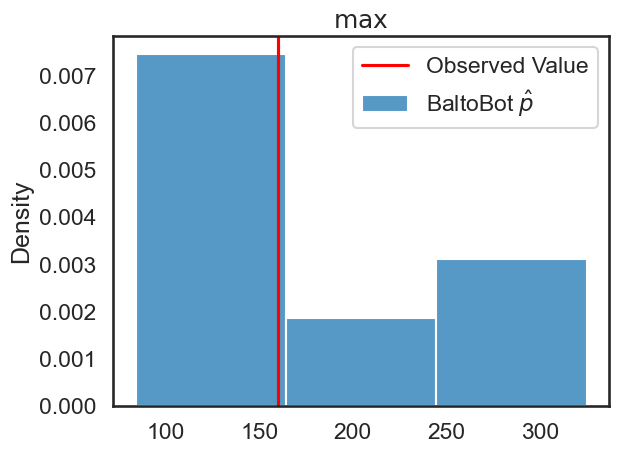

samples [5829 5794 5836 5781 5815 5807 5704 5774 5700 5748 5781 5820 5809 5826
 5894 5786 5773 5777 5767 5836 5828 5813 5838 5763 5734 5772 5806 5810
 5773 5758 5850 5866 5847 5766 5783 5758 5733 5790 5735 5804 5780 5836
 5776 5788 5830 5775 5795 5770 5848 5667 5815 5824 5841 5796 5828 5841
 5765 5780 5785 5831 5852 5805 5814 5781 5804 5837 5822 5813 5769 5778
 5828 5812 5806 5919 5752 5844 5801 5852 5817 5796 5750 5789 5842 5901
 5814 5868 5880 5844 5754 5790 5799 5769 5861 5800 5784 5769 5802 5796
 5793 5847]
title zeros


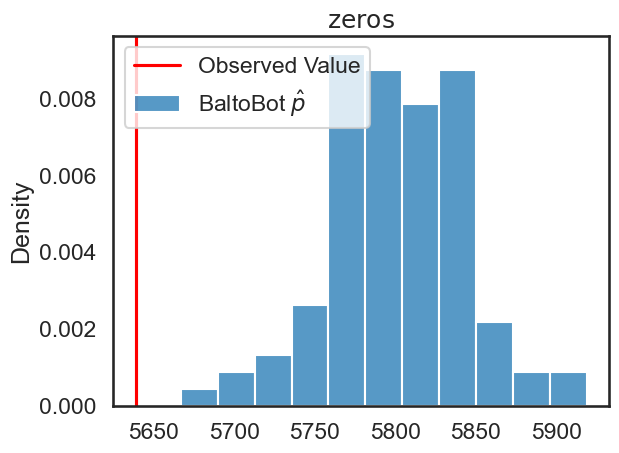

samples [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]


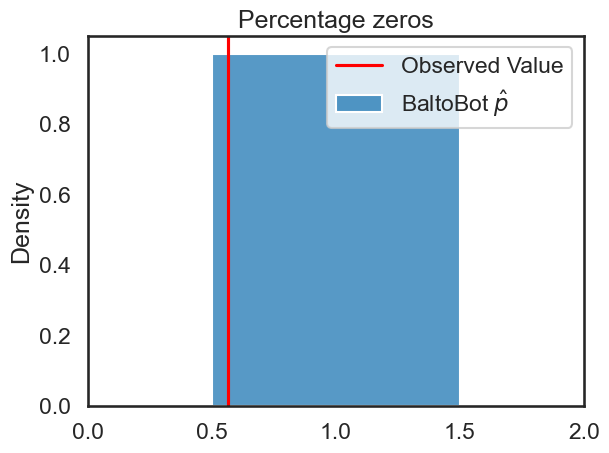

samples [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


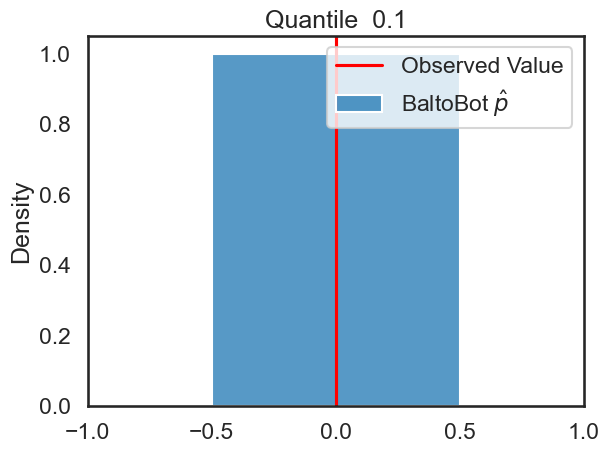

samples [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


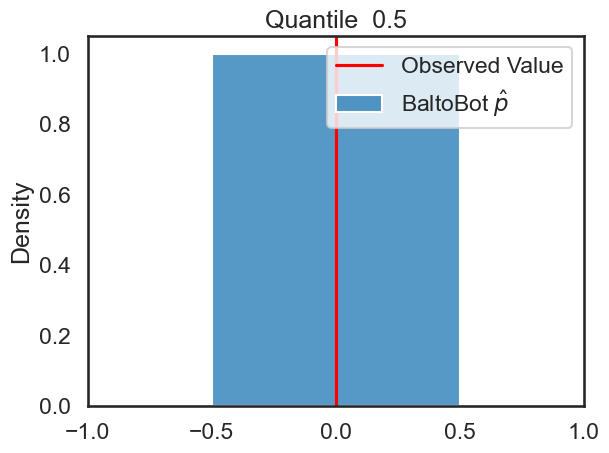

samples [3. 3. 3. 3. 3. 3. 4. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3.]


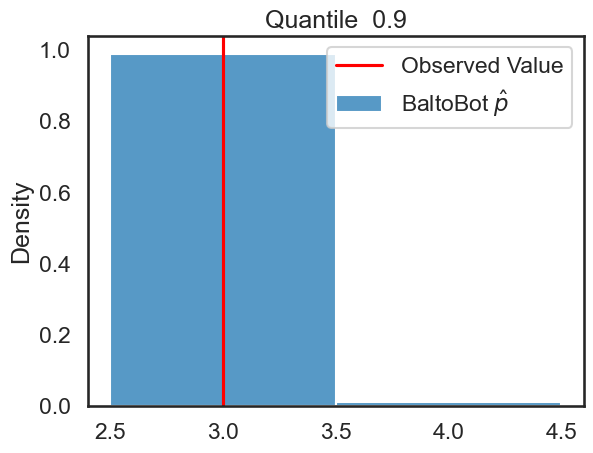

samples [14. 15. 14. 14. 14. 13. 15. 13. 15. 14. 14. 14. 14. 14. 14. 14. 14. 14.
 14. 13. 14. 14. 14. 14. 14. 14. 14. 14. 13. 15. 14. 14. 14. 14. 14. 14.
 14. 14. 14. 15. 14. 15. 13. 15. 14. 14. 15. 14. 14. 14. 13. 14. 14. 14.
 14. 14. 14. 14. 14. 14. 14. 14. 14. 14. 14. 13. 14. 14. 14. 13. 13. 14.
 14. 14. 13. 13. 14. 13. 14. 13. 14. 13. 14. 14. 14. 15. 13. 14. 14. 14.
 15. 13. 14. 14. 14. 14. 14. 13. 13. 14.]
title quantile_ppc_0.99


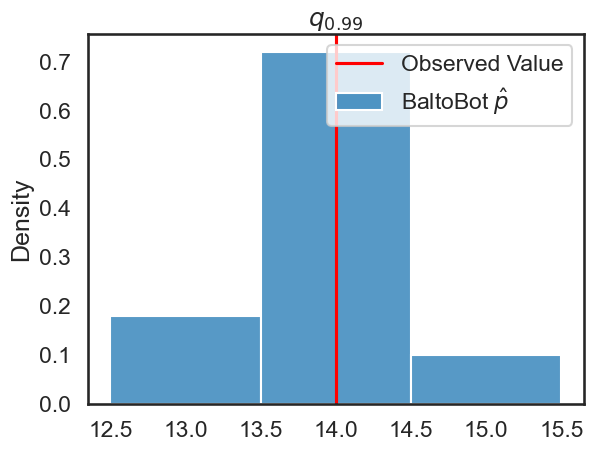

samples [46. 41. 38. 37. 38. 45. 49. 41. 40. 40. 44. 55. 45. 40. 48. 41. 40. 40.
 40. 40. 40. 40. 41. 37. 41. 41. 37. 36. 41. 39. 41. 43. 46. 49. 36. 40.
 40. 38. 39. 40. 39. 43. 40. 40. 42. 41. 38. 40. 40. 37. 41. 52. 41. 40.
 36. 39. 37. 37. 41. 41. 39. 53. 40. 40. 41. 39. 46. 36. 39. 40. 39. 40.
 38. 41. 35. 35. 48. 36. 53. 41. 37. 39. 39. 50. 38. 39. 51. 39. 46. 40.
 38. 37. 36. 40. 41. 37. 39. 37. 40. 40.]


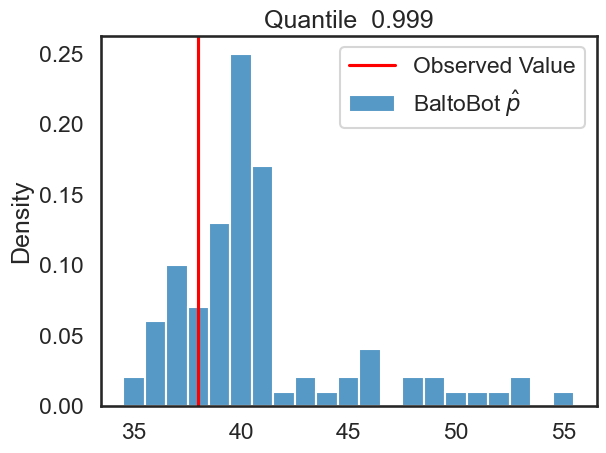

In [31]:
def proc_title(title):
    if title in ppc_tiles:
        print("title", title)
        return ppc_tiles[title]

    x = title.replace("_", " ").capitalize()
    x = x.replace("ppc", "")
    return x

ppc_number = len(ppcs)
ppc_names = results[0]["ppc_results"].keys()

for ppc_name in ppc_names:
    fig, ax = plt.subplots()
    for i, res in enumerate(results):
        model_name = res["model_name"]
        samples = res["ppc_results"][ppc_name]["samples"]
        # make int
        samples = np.maximum(samples, 0)
        samples =  np.round(samples)
        true = res["ppc_results"][ppc_name]["true"]
        n_unique_samples = len(np.unique(samples))
        discrete = n_unique_samples < 20

        print("samples", samples)

        # plot a histogram of the samples but with integers (use nice binning)
        if ppc_name == "max_ppc":
            binwidth = 70
        else:
            binwidth = None
        sns.histplot(samples, ax=ax, label=f"{model_name}" + r" $\hat{p}$", discrete=discrete, stat="density", binwidth=binwidth)
        if i == 0:
            ax.axvline(true, color="red", label="Observed Value")
        ax.set_title(proc_title(f"{ppc_name}"))
        ax.legend()

        if n_unique_samples < 2:
            min_val = np.min(samples) - 1
            max_val = np.max(samples) + 1

            ax.set_xlim(min_val, max_val)



        # save the figure
        fig.savefig(f"m5/{ppc_name}.png", dpi=100)
        # save as pdf
        fig.savefig(f"m5/{ppc_name}.pdf")

        #max_x = true * 5
        #max_samples = np.max(samples)
        #if max_samples > max_x:
        #    ax.set_xlim(0, max_x)


    plt.show()





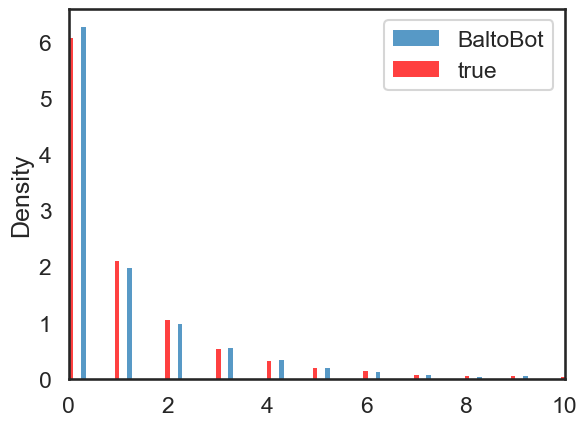

In [32]:
for i, result in enumerate(results):
    samples = result["y_samples"][0]
    samples = np.round(samples) + (i+1)/4
    sns.histplot(samples.flatten(), stat="density", label=result["model_name"])

sns.histplot(y_test_np.flatten(), stat="density", color="red", label="true")
plt.xlim(0, 10)
plt.legend()

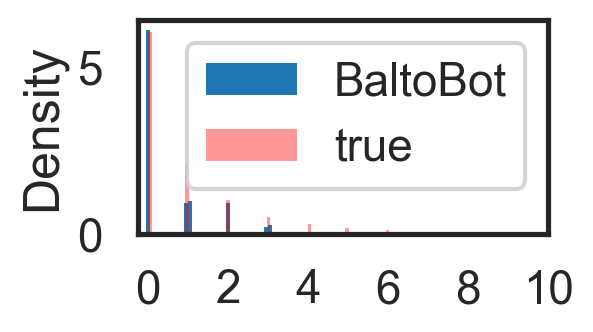

In [33]:
plt.figure(figsize=(3.5,2), dpi=200);
for i, result in enumerate(results):
    samples = result["y_samples"][0]
    #samples = np.round(samples) + (i+1)/4
    sns.histplot(samples.flatten(), stat="density", label=result["model_name"], alpha=1)

sns.histplot(y_test_np.flatten(), stat="density", color="red", label="true", alpha=0.4)
plt.xlim(-0.25, 10)
plt.legend()
plt.tight_layout();
plt.xticks(list(range(11)));
plt.xticks([0, 2, 4, 6, 8, 10]);
plt.savefig('m5-baltobot-notuning-density.png');

mean shape (10,)
lower shape (10,)
upper shape (10,)
y_true shape (10,)
samples shape (1, 100, 10)


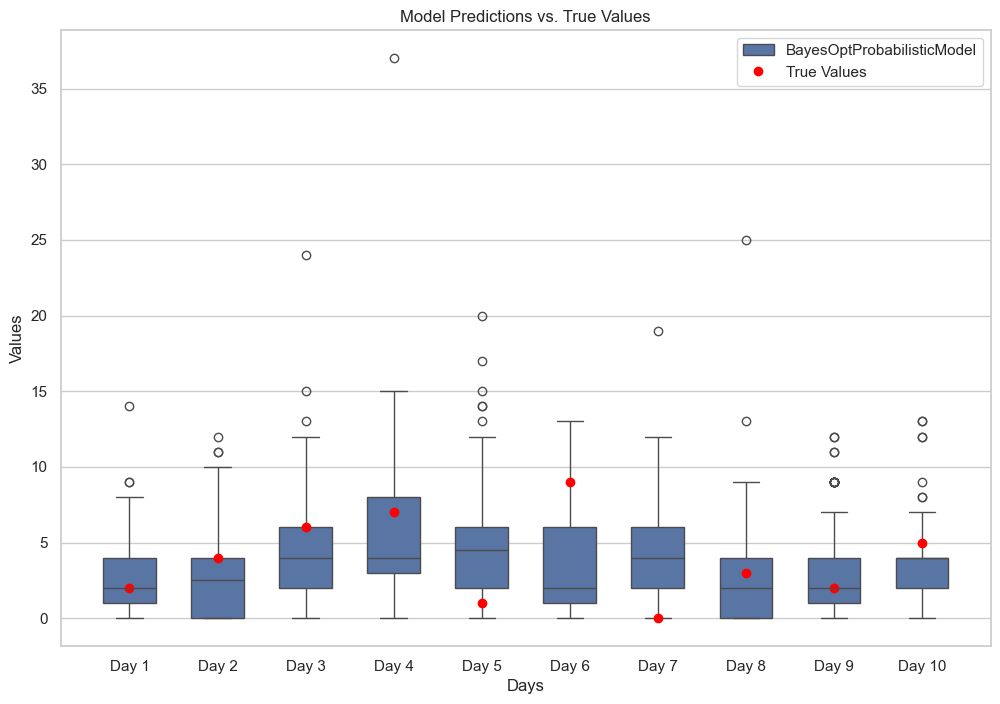

mean shape (10,)
lower shape (10,)
upper shape (10,)
y_true shape (10,)
samples shape (1, 100, 10)


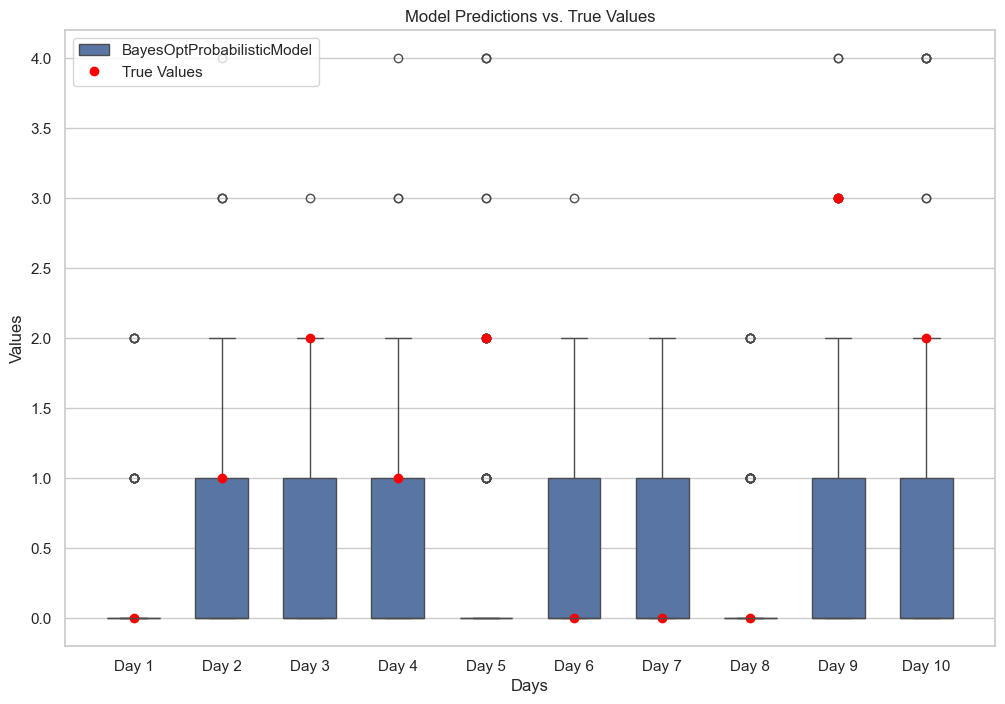

mean shape (10,)
lower shape (10,)
upper shape (10,)
y_true shape (10,)
samples shape (1, 100, 10)


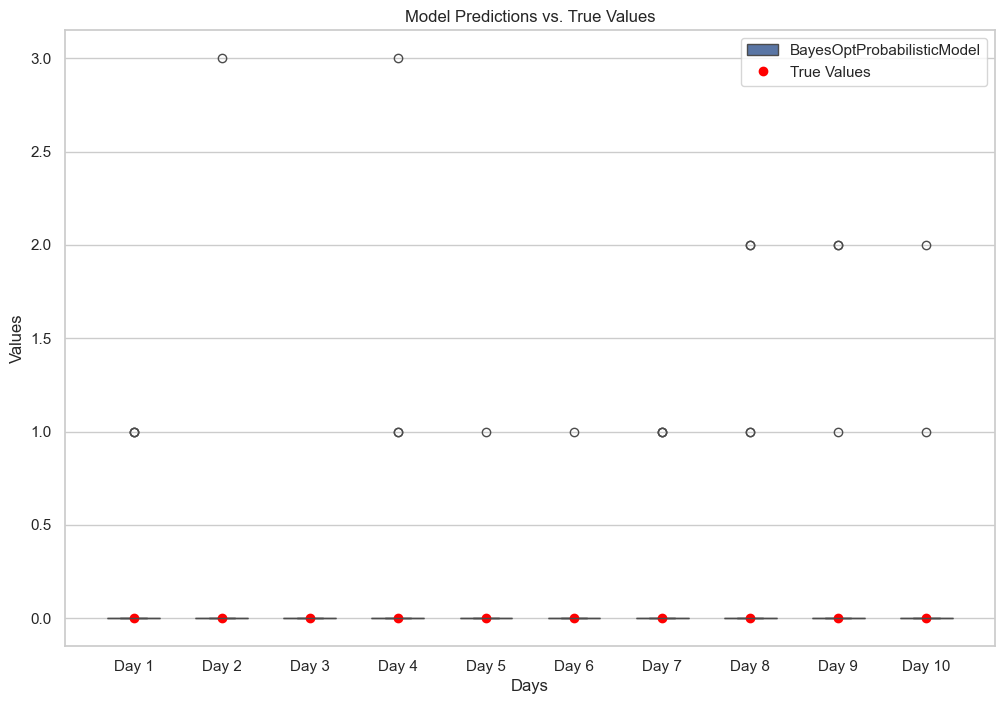

In [34]:
np.random.seed(0)

NUM_PRODS_TO_PLOT = 3
DAYS_TO_PLOT = 10
QUATILE = 0.9
NUM_SAMPLES = 100

prods_to_plot = np.random.choice(range(len(X_train_prod_processed)), NUM_PRODS_TO_PLOT)

means_to_plot = []
lower_q_s = []
upper_q_s = []

prod_dict = {}

for res in results:
    model = res["model"]

    for i in prods_to_plot:
        if i not in prod_dict:
            prod_dict[i] = {
                "means_to_plot": [],
                "lower_q_s": [],
                "upper_q_s": [],
                "samples": []
            }

        X_prod_proc_i = X_train_prod_processed[i][-DAYS_TO_PLOT:]
        y_prod_proc_i = y_train_prod[i][-DAYS_TO_PLOT:]

        samples = model.sample(X_prod_proc_i.values, NUM_SAMPLES)
        samples = samples.astype(int)
        samples = np.maximum(samples, 0)

        means = np.mean(samples, axis=0)
        lower_q = np.quantile(samples, 1-QUATILE, axis=0)
        upper_q = np.quantile(samples, QUATILE, axis=0)

        prod_dict[i]["means_to_plot"].append(means)
        prod_dict[i]["lower_q_s"].append(lower_q)
        prod_dict[i]["upper_q_s"].append(upper_q)
        prod_dict[i]["samples"].append(samples)

for i in prod_dict:
    means_to_plot = np.array(prod_dict[i]["means_to_plot"]).squeeze()
    lower_q_s = np.array(prod_dict[i]["lower_q_s"]).squeeze()
    upper_q_s = np.array(prod_dict[i]["upper_q_s"]).squeeze()
    samples = np.array(prod_dict[i]["samples"]).squeeze(-1)
    y_true = np.array(y_train_prod[i][-DAYS_TO_PLOT:])

    model_names = [res["model"].__class__.__name__ for res in results]

    print("mean shape", means_to_plot.shape)
    print("lower shape", lower_q_s.shape)
    print("upper shape", upper_q_s.shape)
    print("y_true shape", y_true.shape)
    print("samples shape", samples.shape)

    #plot_predictions(y_true, means_to_plot, upper_q_s, lower_q_s, [res["model"].__class__.__name__ for res in results])
    plot_model_comparisons(samples, y_true, model_names=model_names)


# Log-likelihood

In [35]:
for res in results:
    model = res["model"]
    name = res["model_name"]
    nll = LogLikelihoodFromSamplesMetric(n_samples=100).compute(model=model, X_test=X_test_np, y_test=y_test_np, samples=res["y_samples"])
    crps  = CRPS().compute(model=model, X_test=X_test_np, y_test=y_test_np, samples=res["y_samples"])
    print(f"Model {name} has a NLL of {nll}")
    print(f"Model {name} has a CRPS of {crps}")

Model BaltoBot has a NLL of {'nll_samples': 1.2363826138353142}
Model BaltoBot has a CRPS of {'crps_100': 0.6438878869377149}


In [36]:
accuracy = AccuracyMetric().compute(model=model, X_test=X_test_np, y_test=y_test_np)
print(accuracy)
#assert False

{'mae': 0.9752852863705899, 'rmse': 2.061305293402131, 'mdae': 0.5207379213058538, 'marpd': 142.02533400285316, 'r2': 0.7161511938178773, 'corr': 0.8476271338376145}


In [37]:
res["y_samples"].shape

(100, 10000, 1)

# Plot calibration plot

In [38]:
def calibration_plot(y_samples: Float[np.ndarray, "n_samples batch y_dim"], y_test: Float[np.ndarray, "batch y_dim"]) -> None:
    """
    We will plot the calibration plot for the model. Essentially, we will plot the
    """
    assert y_test.shape[1] == 1, "Only works for univariate outputs"
    n_samples = y_samples.shape[0]
    y_samples = np.maximum(y_samples, 0.0)
    y_samples = np.round(y_samples).astype(int)
    y_test = y_test.astype(int)

    # Filter out the zeros
    #non_zero_idx = y_test > 0
    #y_test = y_test[non_zero_idx]
    #y_samples = y_samples[:, non_zero_idx]

    y_test_expanded = y_test[np.newaxis, :].repeat(n_samples, axis=0)
    prob_of_event = np.mean(y_samples <= y_test_expanded, axis=0)
    prob_of_event_sorted = np.sort(prob_of_event.flatten())
    return np.linspace(0, 1, len(prob_of_event)), prob_of_event_sorted










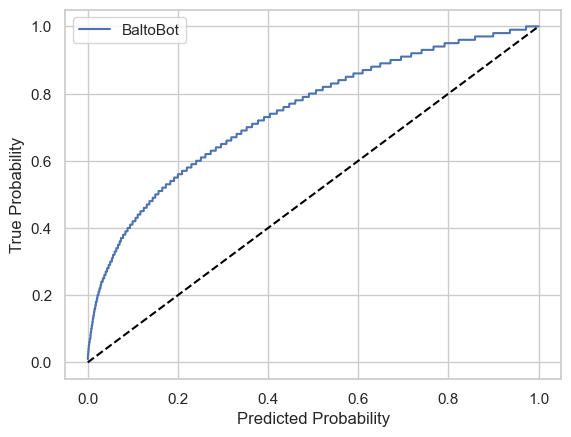

<Axes: ylabel='Count'>

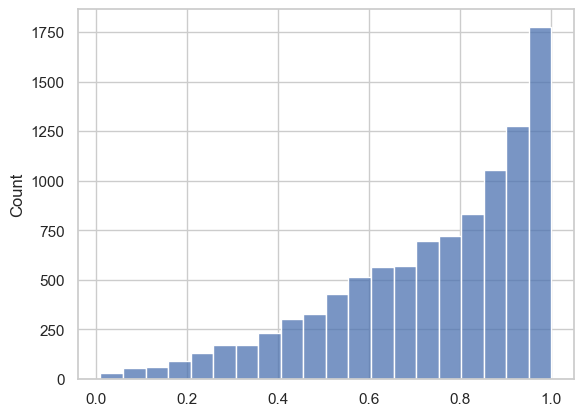

In [39]:
y_ex = None
for res in results:
    samples = res["y_samples"]
    model = res["model"]
    x,y = calibration_plot(samples, y_test_np)
    plt.plot(x, y, label=res["model_name"])
    y_ex = y


plt.plot([0, 1], [0, 1], linestyle="--", color="black")

plt.xlabel("Predicted Probability")
plt.ylabel("True Probability")
plt.legend()

plt.show()

# plot the distribution of y

sns.histplot(y_ex, bins=20)

In [40]:
# Quantile prediction plot for the model
def make_quantile_plot(results):
    quantiles = np.linspace(0.9, 0.999, 10)

    means = []
    stds = []

    for res in results:
        samples = res["y_samples"] # shape [n_samples, batch, y_dim]
        samples = np.maximum(samples, 0)
        samples = np.round(samples)

        m, s = [], []

        for q in quantiles:
            quantile_samples = np.quantile(samples, q, axis=1)
            mean = np.mean(quantile_samples, axis=0)
            std = np.std(quantile_samples, axis=0)
            m.append(mean)
            s.append(std)

        m = np.array(m).squeeze()
        s = np.array(s).squeeze()
        plt.plot(quantiles, m, label=res["model_name"])
        plt.fill_between(quantiles, m - s, m + s, alpha=0.3)

        means.append(m)
        stds.append(s)


    true_quantiles =  []
    for q in quantiles:
        true_quantiles.append(np.quantile(y_test_np, q))

    plt.plot(quantiles, true_quantiles, label="True")

    # set log scale on y axis


    # set log scale on x axis
    plt.xscale("log")
    plt.legend()



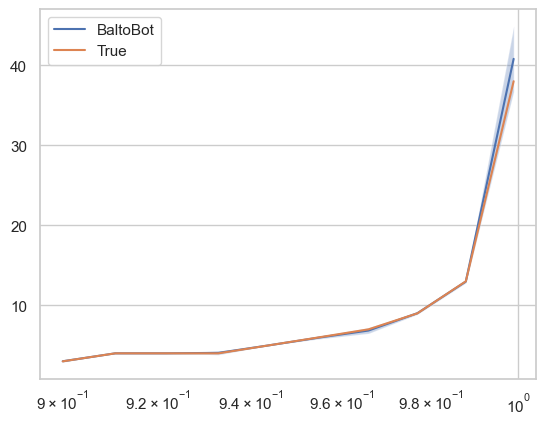

In [41]:
make_quantile_plot(results)

In [42]:
model

BayesOptProbabilisticModel(frac_validation=0.01,
                           learning_rate=0.06479440278672478, max_leaves=0,
                           n_iter_bayes_opt=25, seed=0,
                           subsample=0.5036378899386018)